In [1]:
#importing libaries and initialising my network
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.graph_objects as go
#from plotly.colors import n_colorsy
import Deep_Neural_Network_Script
import mpmath
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

torch.cuda.empty_cache()

device = torch.device("cpu")

#add stuff for starting and ending date
#also create an activation and loss function class to import to all my scripts

#add stuff to classes
#save LSTM predictions and plot them on a graph
poly_model = Deep_Neural_Network_Script.RecurrentNeuralNetwork(
    number_of_hidden_layers = 2, 
    input_layer_size=1,
    hidden_layer_size=200,
    output_layer_size=1, 
    device_used=device, 
    dropout=0.1
    )
saved_model = 'LSTM_2x200_run1.pth'
poly_model.load_state_dict(torch.load(saved_model))


<All keys matched successfully>

Collect the data

In [2]:
#collecting data from csv file

file_name_I1 = 'GlobalTemperatures.csv'
I1_data = pd.read_csv(file_name_I1)
Cummulative_days = I1_data['days ']
Mean_temp = I1_data['Land Average Temperature']
Mean_temp_uncertainty = I1_data['Temp uncertainty']
I1_data.head()



,date,month,year,days,Land Average Temperature,Temp uncertainty,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,1750-01-01,1,1750,30,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,2,1750,60,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,3,1750,90,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,4,1750,120,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,5,1750,150,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


Averaging the recorded temperature from each year

In [3]:
mean_temp = I1_data.groupby('year')['Land Average Temperature'].mean().reset_index()
mean_temp.head()

,year,Land Average Temperature
0,1750,8.719364
1,1751,7.976143
2,1752,5.779833
3,1753,8.388083
4,1754,8.469333


Preprocess the data

In [4]:
start_year = 1918
end_year = 2015
split_year = 1980
batch_size=20 #10
test_size=0.2
sequence_length=7

# Filter the data based on the defined year range
year_range = mean_temp[(mean_temp['year'] >= start_year) & (mean_temp['year'] <= end_year + 1)]
#print(year_range)



# Create the MinMaxScaler and fit it to the data
scaler = MinMaxScaler()
Cleaned_data = scaler.fit_transform(year_range.values)

#obtain the sequence
 #as tech advancements happen roughly every decade
years_sequence, temperatures = [], []
for i in range(len(year_range) - sequence_length):
    years_sequence.append(Cleaned_data[:,0][i:i + sequence_length])
    temperatures.append(Cleaned_data[:,1][i + sequence_length]) #next time step


#find the index of the split year
split_idx = year_range[year_range['year'] <= split_year].index[-1] + 1
print(split_idx)

modelling_years_sequence = years_sequence[:split_idx]
modelling_temperatures = temperatures[:split_idx]
testing_years_sequence = years_sequence[split_idx:]
testing_temperatures = temperatures[split_idx:]


x_train, x_val, y_train, y_val = train_test_split(modelling_years_sequence, modelling_temperatures, test_size=test_size)

x_train_tensor = torch.tensor(x_train, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)
y_train_tensor = torch.tensor(y_train, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)
x_val_tensor = torch.tensor(x_val, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)
y_val_tensor = torch.tensor(y_val, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)

#batch the data
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

231


/tmp/ipykernel_9177/2171389386.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  x_train_tensor = torch.tensor(x_train, dtype = torch.float32).unsqueeze(-1).to(poly_model.device_used)


In [5]:
#training the model
num_epochs = 1000#10000
#batch_size = 100
freq = 10#size of each array collected below
loss_array, iteration_array, val_loss_array, lr_array = np.zeros(int(freq)), np.zeros(int(freq)), np.zeros(int(freq)), np.zeros(int(freq))
i_indication = 0
collection_rate = int(num_epochs/(freq))
loss_function = nn.MSELoss()#Deep_Neural_Network_Script.RMSLELoss()
weight_decay = 1e-5 # l2 regularisation
optimizer = optim.Adam(poly_model.parameters(), lr =0.0001, weight_decay=weight_decay)#


for epoch in range(num_epochs):
    poly_model.train()
    for batch in train_loader:
        x_train, y_train = batch
        
        
        y_pred = poly_model.forward(x_train)
        loss = loss_function(y_pred, y_train)
       

        #backward
        loss.backward()
        optimizer.step()
    if (epoch + 1) % collection_rate == 0: #10000   
        poly_model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_batch in val_loader:
                x_val, y_val = val_batch
                y_pred_val = poly_model.forward(x_val)
                val_loss += loss_function(y_pred_val, y_val)
            val_loss = val_loss/len(val_loader)
         #   for param in poly_model.parameters():
          #      if param.grad is not None:
           #         print(param.grad.data.norm())
            
            #plt.plot(normalised_Cummulative_days, poly_model.forward(torch.tensor(normalised_Cummulative_days, dtype = torch.float32).reshape(-1,1,1)).detach().numpy(), color = "red", label = "RNN")
            #plt.plot(normalised_Cummulative_days, normalised_Mean_temp, color = 'blue', label = "actual temp")
            #plt.legend()
            #plt.show()
            #scheduler room 
            print(f'Epoch  [{epoch+1}/{num_epochs}],   Loss: {loss.item():.8f} ,   Val Loss: {val_loss.item():.8f}')
            loss_array[i_indication] = loss
            val_loss_array[i_indication] = val_loss
            iteration_array[i_indication] = epoch + 1
            i_indication = i_indication + 1
            
       
      




Epoch  [100/1000],   Loss: 0.11493441 ,   Val Loss: 0.13851610
Epoch  [200/1000],   Loss: 0.19188310 ,   Val Loss: 0.28566274
Epoch  [300/1000],   Loss: 0.06081308 ,   Val Loss: 0.15847193
Epoch  [400/1000],   Loss: 0.02251770 ,   Val Loss: 0.06052986
Epoch  [500/1000],   Loss: 0.03557674 ,   Val Loss: 0.02619674
Epoch  [600/1000],   Loss: 0.01711128 ,   Val Loss: 0.01414586
Epoch  [700/1000],   Loss: 0.01759927 ,   Val Loss: 0.01340005
Epoch  [800/1000],   Loss: 0.01018443 ,   Val Loss: 0.01062502
Epoch  [900/1000],   Loss: 0.00948169 ,   Val Loss: 0.01437819
Epoch  [1000/1000],   Loss: 0.00509317 ,   Val Loss: 0.01244418


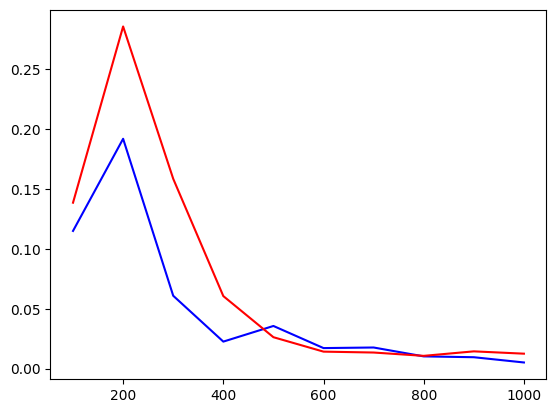

In [37]:
plt.plot(iteration_array, loss_array, 'blue')
plt.plot(iteration_array, val_loss_array, 'red')

torch.save(poly_model.state_dict(),saved_model)
#weight decay

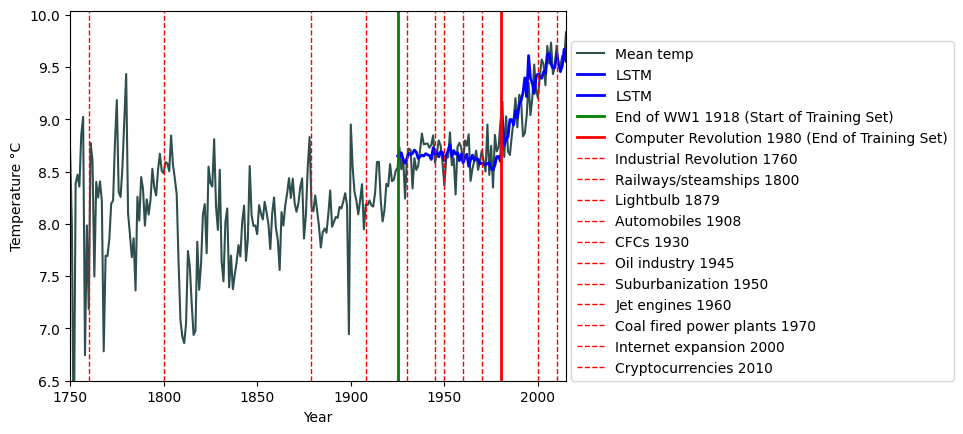

In [5]:
#Important historical dates for innovation
#1760 - Industrial revolution begins
#1800 - Expansion of railways and steamships
#1879 - Invention of the lightbulb
#1908 - Mass production of automobiles
#1930 - Developement of synthetic chemicals (CFCs)
#1945 - Rise of the oil industry
#1950 - Expansion of the Suburbs
#1960 - Introduction of jet engines
#1970 - Introduction of coal fired power plants
#1980 - Advent of computer and digital revolution
#2000 - Expansion of the internet and Data centres (internet, cloud computing etc)
#2010 - Rise of cryptocurrencies

div = 1

#max_temp = poly_model.forward(torch.tensor(max(y_data), dtype = torch.float32).reshape(-1,1,1)).detach().numpy()[0][0]
#min_temp = poly_model.forward(torch.tensor(min(y_data), dtype = torch.float32).reshape(-1,1,1)).detach().numpy()[0][0]


#cleaned_data

#print(year_range['Land Average Temperature'])

#print(torch.tensor(Cleaned_data[:,0], dtype=torch.float32))

max_temp = max(year_range['Land Average Temperature'])
min_temp = min(year_range['Land Average Temperature'])
#print(torch.tensor(years_sequence).unsqueeze(-1).shape)
#print(poly_model.forward(torch.tensor(years_sequence, dtype = torch.float32).unsqueeze(-1)).detach().numpy()*(max_temp-min_temp)+min_temp)

#print(years_sequence)

#plt.plot(year_range['year'], year_range['Land Average Temperature'], color = 'blue', label = "actual temp")
plt.plot(mean_temp['year'], mean_temp['Land Average Temperature'], color = 'darkslategrey', label = "Mean temp")
plt.plot(year_range[sequence_length:], poly_model.forward(torch.tensor(years_sequence, dtype = torch.float32).unsqueeze(-1)).detach().numpy()*(max_temp-min_temp)+min_temp, linewidth = 2, color = 'blue', label = 'LSTM')#*(max_temp-min_temp)+min_temp)
plt.axvline(x=start_year+sequence_length, color='green', linestyle='-', linewidth=2, label = 'End of WW1 1918 (Start of Training Set)')
plt.axvline(x=split_year, color='red', linestyle='-', linewidth=2, label = 'Computer Revolution 1980 (End of Training Set)')


historical_innovation = [1760, 1800, 1879,1908,1930,1945,1950,1960,1970,2000,2010]#[1760,1800,1879,1908,1930,1945,1950,1960,1970,1980,2000,2010]
innovation_labels = ['Industrial Revolution 1760', 'Railways/steamships 1800', 'Lightbulb 1879' , 'Automobiles 1908', 
                     'CFCs 1930' , 'Oil industry 1945', 'Suburbanization 1950', 'Jet engines 1960', 'Coal fired power plants 1970', 'Internet expansion 2000', 'Cryptocurrencies 2010']
#['Industrial Revolution', 'Railways/steamships', 'Lightbulb', 'Automobiles', 
                     #'CFCs', 'Oil industry', 'Suburbanization', 'Jet engines', 'Coal fired power plants', 'Computer revolution', 'Internet expansion', 'Cryptocurrencies']

colors = ['red']
for x, label in zip(historical_innovation, innovation_labels):#, colors):
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1, label = label)

#plt.xlim(1918,end_year)
#plt.xlim(1750, end_year)
plt.xlim(1750, end_year)
plt.ylim(6.5)

plt.xlabel('Year')
plt.ylabel('Temperature °C')
plt.legend(loc = (1.01,0))




Ensemble learning train multiple models and average them